In [2]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import preprocessing
import cv2
import glob
import os
import warnings as wr

wr.filterwarnings("ignore")

In [3]:
traindata_path=r'C:\Users\vvv40\OneDrive\Desktop\resources\Train\Train\JPEGImages'
traindata_annot=r'C:\Users\vvv40\OneDrive\Desktop\resources\Train\Train\Annotations'

testdata_path=r'C:\Users\vvv40\OneDrive\Desktop\resources\Test\Test\JPEGImages'
testdata_annot=r'C:\Users\vvv40\OneDrive\Desktop\resources\Test\Test\Annotations'

In [4]:
import glob
import xml.etree.ElementTree as ET
import pandas as pd

def creatingInfoData(Annotpath):
    information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'name': [], 'label': []}

    for file in sorted(glob.glob(str(Annotpath + '/*.xml*'))):
        dat = ET.parse(file)
        for element in dat.iter():
            if 'object' == element.tag:
                name = None
                xmin, ymin, xmax, ymax = None, None, None, None
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text
                    if 'bndbox' == attribute.tag:
                        for dim in list(attribute):
                            if 'xmin' == dim.tag:
                                xmin = int(round(float(dim.text)))
                            if 'ymin' == dim.tag:
                                ymin = int(round(float(dim.text)))
                            if 'xmax' == dim.tag:
                                xmax = int(round(float(dim.text)))
                            if 'ymax' == dim.tag:
                                ymax = int(round(float(dim.text)))

                if name is not None and xmin is not None and ymin is not None and xmax is not None and ymax is not None:
                    information['label'].append(name)
                    information['name'].append(file.split('/')[-1][0:-4])
                    information['xmin'].append(xmin)
                    information['ymin'].append(ymin)
                    information['xmax'].append(xmax)
                    information['ymax'].append(ymax)

    return pd.DataFrame(information)

# Example usage
Annotpath = 'C:/Users/vvv40/OneDrive/Desktop/resources/Pedestrian detection data/Val/Annotations'
df = creatingInfoData(Annotpath)
print(df)


     xmin  ymin  xmax  ymax                     name        label
0       1   107   322   350    Annotations\image (1)       person
1       1    65   218   343    Annotations\image (1)       person
2     173   169   350   370   Annotations\image (10)       person
3     238   160   297   254   Annotations\image (10)       person
4      77     1   380   599  Annotations\image (100)  person-like
..    ...   ...   ...   ...                      ...          ...
328    50    41   466   528   Annotations\image (97)  person-like
329   342   621   382   716   Annotations\image (97)       person
330   369   617   407   715   Annotations\image (97)       person
331   215     1   384   319   Annotations\image (98)  person-like
332    11    12   149   301   Annotations\image (99)  person-like

[333 rows x 6 columns]


In [5]:
train_info=creatingInfoData(traindata_annot)
test_info=creatingInfoData(testdata_annot)

In [ ]:
print(df)

Train Counts:
label
person         1106
person-like     960
Name: count, dtype: int64
Test Counts:
label
person         317
person-like    278
Name: count, dtype: int64


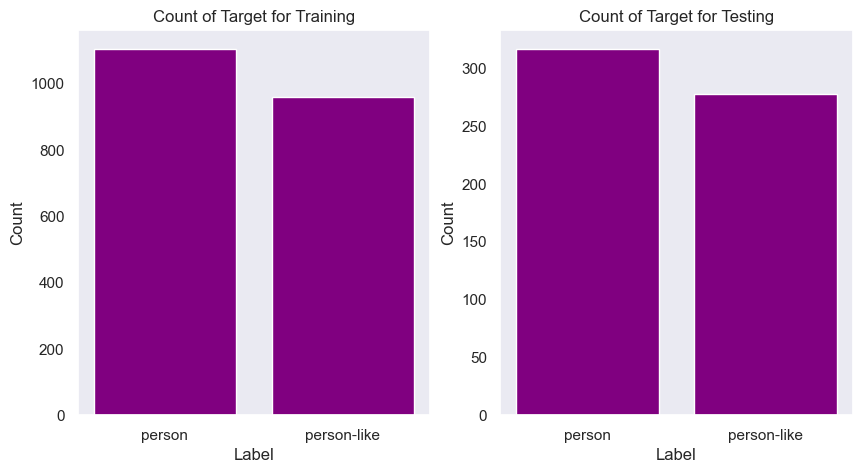

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

if len(axes) == 2:
    # Check counts and labels for training data
    train_counts = train_info['label'].value_counts()
    print("Train Counts:")
    print(train_counts)
    
    # Check counts and labels for testing data
    test_counts = test_info['label'].value_counts()
    print("Test Counts:")
    print(test_counts)
    
    # Plot for training data with purple bars
    axes[0].bar(train_counts.index, train_counts, color='purple')
    axes[0].set_title('Count of Target for Training')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Count')

    # Plot for testing data with purple bars
    axes[1].bar(test_counts.index, test_counts, color='purple')
    axes[1].set_title('Count of Target for Testing')
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Count')

    plt.show()
else:
    print("Number of axes is not 2. Check the subplot setup.")


In [8]:
# Display specific columns for the image (101)
print(df[['name', 'label', 'xmin', 'ymin', 'xmax', 'ymax']].head())


                      name        label  xmin  ymin  xmax  ymax
0    Annotations\image (1)       person     1   107   322   350
1    Annotations\image (1)       person     1    65   218   343
2   Annotations\image (10)       person   173   169   350   370
3   Annotations\image (10)       person   238   160   297   254
4  Annotations\image (100)  person-like    77     1   380   599


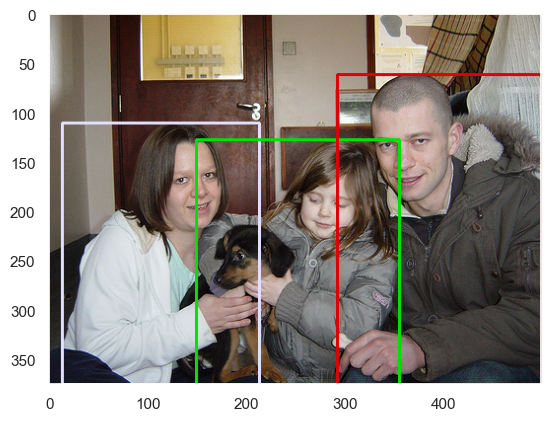

In [10]:
import cv2
img=cv2.imread(traindata_path+'/image (101).jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

cv2.rectangle(img,(13,110),(213,375),(225,225,255),2)
cv2.rectangle(img,(149,127),(355,375),(0,225,0),2)
cv2.rectangle(img,(292,61),(500,375),(225,0,0),2)

plt.imshow(img)

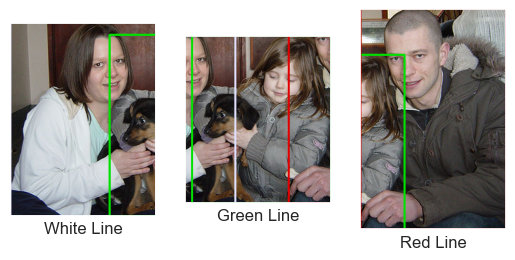

In [11]:
#  y-min, y-max , x-min , x-max
fig=plt.figure()

plt.subplot(1,3,1)
plt.imshow(img[110:375,13:213])
plt.xticks([])
plt.yticks([])
plt.xlabel('White Line')

plt.subplot(1,3,2)
plt.imshow(img[127:375,139:355])
plt.xticks([])
plt.yticks([])
plt.xlabel('Green Line')

plt.subplot(1,3,3)
plt.imshow(img[61:375,292:500])
plt.xticks([])
plt.yticks([])
plt.xlabel('Red Line')

plt.show()


splitting objects for the image

In [12]:
def croppingFromImage(path,Data_information):
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]
        cropped_image.append(img_)
        
        label.append(Data_information['label'][i])
    return cropped_image , label     

In [13]:
# Define or import the function load_training_images
def load_training_images():
    # Your code to load training images goes here
    # For example, assuming your function returns a list of images
    loaded_images = []  # Placeholder, replace with actual code

    # Make sure to populate the list with loaded images

    return loaded_images

# Define or import the function load_training_labels
def load_training_labels():
    # Your code to load training labels goes here
    # For example, assuming your function returns a list of labels
    loaded_labels = []  # Placeholder, replace with actual code

    # Make sure to populate the list with loaded labels

    return loaded_labels

# Now you can use the functions to load training images and labels
trainImage = load_training_images()
trainLabel = load_training_labels()

# Check if trainImage and trainLabel are not None before using them
if trainImage is not None and trainLabel is not None:
    # Now you can use the variables in your print statement
    print(len(trainImage) == len(trainLabel))
else:
    print("Loading training images or labels failed.")


True


Making the iamges to be visible from the dataset

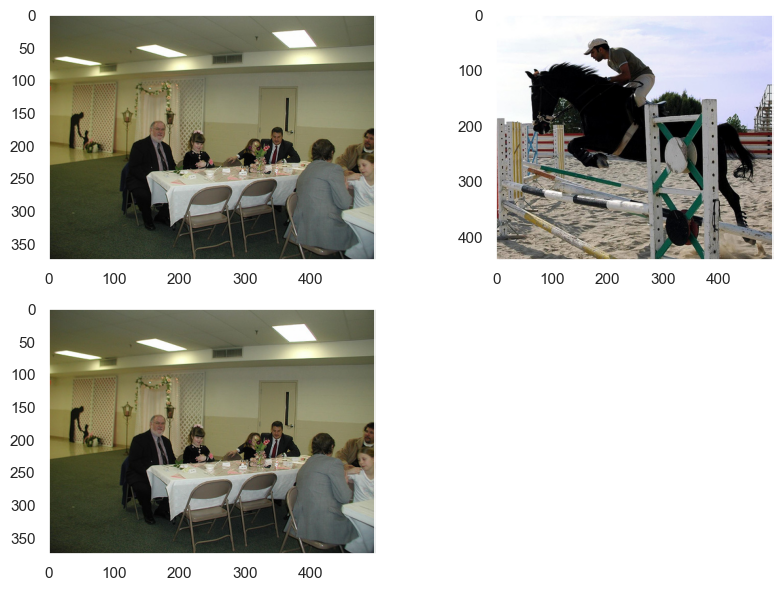

In [14]:
from PIL import Image

# Define or import the function load_training_paths
def load_training_paths():
    # Your code to load training paths goes here
    # For example, assuming you have a list of file paths
    return [r'C:\Users\vvv40\OneDrive\Desktop\resources\Train\Train\JPEGImages\image (1).jpg',
            r'C:\Users\vvv40\OneDrive\Desktop\resources\Train\Train\JPEGImages\image (2).jpg',
            r'C:\Users\vvv40\OneDrive\Desktop\resources\Train\Train\JPEGImages\image (3).jpg']

# Now you can use the function to load training paths
train_path = load_training_paths()

# Check if there are paths in train_path
if len(train_path) > 0:
    fig = plt.figure(figsize=(10, 7))
    
    for i in range(1, min(4, len(train_path) + 1)):
        random_index = np.random.randint(0, len(train_path))
        
        # Read the image using PIL
        img_path = train_path[random_index]
        img = Image.open(img_path)
        
        plt.subplot(2, 2, i)
        plt.imshow(img, cmap='gray')  # Adjust cmap if necessary
        
    plt.show()
else:
    print("train_path is empty.")


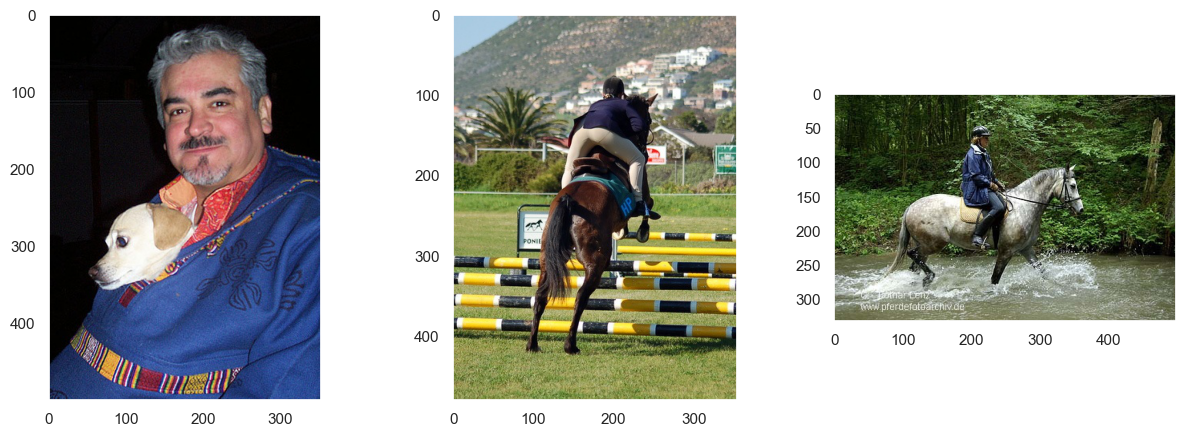

In [15]:
from PIL import Image

# Define or import the function load_testing_paths
def load_testing_paths():
    # Your code to load testing paths goes here
    # For example, assuming you have a list of file paths
    return [r'C:\Users\vvv40\OneDrive\Desktop\resources\Test\Test\JPEGImages\image (1).jpg',
            r'C:\Users\vvv40\OneDrive\Desktop\resources\Test\Test\JPEGImages\image (2).jpg',
            r'C:\Users\vvv40\OneDrive\Desktop\resources\Test\Test\JPEGImages\image (3).jpg']

# Now you can use the function to load testing paths
test_path = load_testing_paths()

# Check if there are paths in test_path
if len(test_path) > 0:
    fig = plt.figure(figsize=(15, 5))  # Adjust the figure size based on your preference
    
    for i in range(1, len(test_path) + 1):  # Loop through all images
        img_path = test_path[i - 1]  # Adjust the index to start from 0
        img = Image.open(img_path)
        
        plt.subplot(1, len(test_path), i)  # 1x3 grid
        plt.imshow(img, cmap='gray')  # Adjust cmap if necessary
        
    plt.show()
else:
    print("test_path is empty.")


Reshaping the dataset

In [16]:
from PIL import Image

# Assuming trainImage is a list of image file paths
trainImage = [
    r'C:\Users\vvv40\OneDrive\Desktop\resources\Pedestrian detection data\Val\JPEGImages\image (1).jpg',
    r'C:\Users\vvv40\OneDrive\Desktop\resources\Pedestrian detection data\Val\JPEGImages\image (2).jpg'
]

trainShapes = []

for i, img_path in enumerate(trainImage):
    try:
        img = Image.open(img_path)
        width, height = img.size
        trainShapes.append((width, height))
    except Exception as e:
        print(f"Error processing image {i + 1}: {str(e)}")


Considering the most frequent shapes

In [17]:
pd.Series(trainShapes).value_counts()[:10]

(333, 500)    1
(500, 369)    1
Name: count, dtype: int64

In [21]:
import pandas as pd

# Assuming you have a list called testShapes
testShapes = [(4, 5), (5, 6)]

# Convert the list to a pandas Series and get value counts
value_counts = pd.Series(testShapes).value_counts()[:10]

# Print the top 10 value counts
print(value_counts)


(4, 5)    1
(5, 6)    1
Name: count, dtype: int64


There's observe that cropped objects doesnot has frequent shape and actually this is logical

In [22]:
def resizing(data,size):
    resizing=[]
    for i in data:
        resizing.append(cv2.resize(i,(size,size)))
        
    return resizing  

In [26]:
from PIL import Image

# Assuming testImage is a list of image file paths
testImage = [r'C:\Users\vvv40\OneDrive\Desktop\resources\Test\Test\JPEGImages\image (1).jpg', r'C:\Users\vvv40\OneDrive\Desktop\resources\Test\Test\JPEGImages\image (2).jpg']

testShapes = []

for i, img_path in enumerate(testImage):
    try:
        img = Image.open(img_path)
        width, height = img.size
        testShapes.append((width, height))
    except Exception as e:
        print(f"Error processing image {i + 1}: {str(e)}")


In [27]:
import os

def load_labels(directory_path):
    labels = []
    try:
        for filename in os.listdir(directory_path):
            filepath = os.path.join(directory_path, filename)
            with open(filepath, 'r') as file:
                label = file.read().strip()
                labels.append(label)
        return labels
    except FileNotFoundError:
        print(f"Error: Directory '{directory_path}' not found.")
        return []

# Specify the directory path containing label files
directory_path = r'C:\Users\vvv40\OneDrive\Desktop\resources\Test\Test\Annotations'

# Load labels from the specified directory
testLabel = load_labels(directory_path)


Feature Extraction

In [33]:
# Run the code for resizing images first to define X_train
# ...

# Convert list to array
X_train = np.asarray(X_train).astype(np.float32)

# Normalize the pixel values to the range [0, 1]
X_train = X_train / 255.0


Random forest 

In [34]:
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten
from sklearn.ensemble import RandomForestClassifier


In [35]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten
from sklearn.ensemble import RandomForestClassifier



TensorFlow version: 2.15.0


In [36]:
model = Sequential()

#1st conv layer
model.add(Conv2D(32, (4,10), padding="same",input_shape=(s,s,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2nd conv layer
model.add(Conv2D(32, (4,10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())
#3rd conv layer
model.add(Conv2D(64, (4,10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4th conv layer
model.add(Conv2D(64, (4,10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())



In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 140, 140, 32)      3872      
                                                                 
 batch_normalization (Batch  (None, 140, 140, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 140, 140, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 140, 140, 32)      40992     
                                                                 
 batch_normalization_1 (Bat  (None, 140, 140, 32)      128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 140, 140, 32)      0

In [38]:
x_train_feature=model.predict(X_train)

1/1 [==============================] - 1s 601ms/step


In [39]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Example data (replace with your actual data)
x_train_feature = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y_train = np.array([0, 1, 0])

# Initialize and fit the Random Forest classifier
forest = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=2)
forest.fit(x_train_feature, y_train)


RandomForestClassifier(max_depth=2, n_estimators=10, random_state=42)

In [40]:
print(forest.score(x_train_feature,y_train))

1.0


Neural Network

In [41]:
##build NN
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense , Dropout , Activation
model = Sequential()
model.add(Dense(120 , input_shape =(x_train_feature.shape) ))
model.add(Activation('relu'))
model.add(Dropout(.2))

model.add(Dense(120 ))
model.add(Activation('relu'))
model.add(Dropout(.2))

model.add(Dense(2))
model.add(Activation('sigmoid'))

In [42]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Example data (replace with your actual data)
x_train_feature = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y_train = np.array([0, 1, 0])

# Define the neural network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=x_train_feature.shape[1]))
model.add(Dense(units=1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
model.fit(x_train_feature, y_train, epochs=10, batch_size=1, verbose=1)



Epoch 1/10


3/3 [==============================] - 2s 15ms/step - loss: 0.6808 - accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 0s 8ms/step - loss: 0.6638 - accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 0s 7ms/step - loss: 0.6515 - accuracy: 0.6667
Epoch 4/10
3/3 [==============================] - 0s 7ms/step - loss: 0.6538 - accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 0s 6ms/step - loss: 0.6440 - accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 0s 8ms/step - loss: 0.6501 - accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 0s 7ms/step - loss: 0.6466 - accuracy: 0.6667
Epoch 8/10
3/3 [==============================] - 0s 7ms/step - loss: 0.6417 - accuracy: 0.6667
Epoch 9/10
3/3 [==============================] - 0s 5ms/step - loss: 0.6400 - accuracy: 0.6667
Epoch 10/10
3/3 [==============================] - 0s 6ms/step - loss: 0.6429 - accuracy: 0.6667


Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier

# Create and train a Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train_feature, y_train)


DecisionTreeClassifier(random_state=42)

Ada Boost

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and train an AdaBoostClassifier with Decision Tree base models
adaboost_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
adaboost_model.fit(x_train_feature, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                   random_state=42)

Bagging

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and train a BaggingClassifier with Decision Tree base models
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
bagging_model.fit(x_train_feature, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=50, random_state=42)